In [1]:
import wrangle

import pandas as pd
pd.options.display.max_rows = 100

import matplotlib.pyplot as plt
import seaborn as sns

>## Acquiring data through wrangle.py


In [2]:
df=wrangle.get_zillow_data()

>## Defining the dataset

In [3]:
#seeing what dataset looks like
wrangle.df_summary(df)

---Shape: (52319, 68)

---Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52319 entries, 0 to 52318
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            52319 non-null  int64  
 1   parcelid                      52319 non-null  int64  
 2   airconditioningtypeid         13615 non-null  float64
 3   architecturalstyletypeid      70 non-null     float64
 4   basementsqft                  47 non-null     float64
 5   bathroomcnt                   52319 non-null  float64
 6   bedroomcnt                    52319 non-null  float64
 7   buildingclasstypeid           0 non-null      float64
 8   buildingqualitytypeid         33654 non-null  float64
 9   calculatedbathnbr             52184 non-null  float64
 10  decktypeid                    389 non-null    float64
 11  finishedfloor1squarefeet      4371 non-null   float64
 12  calculatedfinishedsquarefeet 

>## Handling nulls and missing values:

In [4]:
#setting up missing values function, to catch only the %%% of data that
#is already there, and not missing.

#checking nulls by columns of the percent of nulls found:

wrangle.nulls_by_columns(df).sort_values(by='percent', ascending=False)


,count,percent
buildingclassdesc,52319,1.000000
buildingclasstypeid,52319,1.000000
finishedsquarefeet15,52319,1.000000
finishedsquarefeet13,52319,1.000000
storytypeid,52272,0.999102
basementsqft,52272,0.999102
storydesc,52272,0.999102
yardbuildingsqft26,52256,0.998796
architecturalstyletypeid,52249,0.998662
architecturalstyledesc,52249,0.998662


In [5]:
#now let's look at nulls by rows:
wrangle.nulls_by_rows(df)

n_missing  percent_missing
23         0.338235               2
24         0.352941              12
25         0.367647              11
26         0.382353              30
27         0.397059             177
28         0.411765             390
29         0.426471            2527
30         0.441176            2199
31         0.455882            5989
32         0.470588            8885
33         0.485294           11967
34         0.500000           11157
35         0.514706            3469
36         0.529412            4138
37         0.544118            1020
38         0.558824             223
39         0.573529              29
40         0.588235              15
41         0.602941               6
42         0.617647               7
43         0.632353              10
44         0.647059              46
45         0.661765               6
46         0.676471               1
47         0.691176               1
48         0.705882               2
dtype: int64

### TAKE AWAYS:
- For missing values in columns, there is a big difference between regionneighborhood (60% missing) vs building quality type (38%), so I will will set my columns at 60%, since I do want to capture the regionneighborhood.
- Columns missing values I'll keep at 60% as it looks to be a good split on what is missing.

In [6]:
#using 60/60 first to see what dataset looks like:
print('Before dropping nulls, %d rows, %d cols' % df.shape)

#dropping the cols & rows that do not meet the 60/60 standard
df = wrangle.handle_missing_values(df, prop_required_column=.6, prop_required_row=.60)
print('After dropping nulls, %d rows, %d cols' % df.shape)

Before dropping nulls, 52319 rows, 68 cols
After dropping nulls, 52319 rows, 34 cols


In [7]:
#taking a look at what nulls are left
df.isnull().sum()

id                                  0
parcelid                            0
bathroomcnt                         0
bedroomcnt                          0
buildingqualitytypeid           18665
calculatedbathnbr                 135
calculatedfinishedsquarefeet       81
finishedsquarefeet12              246
fips                                0
fullbathcnt                       135
heatingorsystemtypeid           18470
latitude                            0
longitude                           0
lotsizesquarefeet                 366
propertycountylandusecode           0
propertylandusetypeid               0
propertyzoningdesc              18558
rawcensustractandblock              0
regionidcity                     1036
regionidcounty                      0
regionidzip                        26
roomcnt                             0
unitcnt                         18558
yearbuilt                         114
structuretaxvaluedollarcnt         82
taxvaluedollarcnt                   1
assessmentye

#### For my next null steps:
    - I'll drop all the larger null columns.
    - I'll drop all columns that reiterate information too.
    - I'll then decide what to do with leftover row nulls

In [8]:
#creating a function to remove unwanted columns (*may add/change later)

cols_to_remove = ['propertycountylandusecode','propertylandusedesc','propertyzoningdesc','buildingqualitytypeid','heatingorsystemtypeid','unitcnt','heatingorsystemdesc','calculatedbathnbr','id','finishedsquarefeet12','fullbathcnt','structuretaxvaluedollarcnt','landtaxvaluedollarcnt','taxamount','regionidcity','censustractandblock','transactiondate']
def remove_columns(df, cols_to_remove): 
    df = df.drop(columns=cols_to_remove)
    return df

df= remove_columns(df, cols_to_remove )
df.isnull().sum()

parcelid                          0
bathroomcnt                       0
bedroomcnt                        0
calculatedfinishedsquarefeet     81
fips                              0
latitude                          0
longitude                         0
lotsizesquarefeet               366
propertylandusetypeid             0
rawcensustractandblock            0
regionidcounty                    0
regionidzip                      26
roomcnt                           0
yearbuilt                       114
taxvaluedollarcnt                 1
assessmentyear                    0
logerror                          0
dtype: int64

In [9]:
#considering how to handle each low count null...
df.lotsizesquarefeet.mean()

11323.453910265047

In [10]:
#looking at value_counts() for each leftover nulls
df.lotsizesquarefeet.value_counts()

6000.0     873
5000.0     413
7200.0     306
7000.0     285
6500.0     272
          ... 
18024.0      1
20673.0      1
4775.0       1
9367.0       1
47405.0      1
Name: lotsizesquarefeet, Length: 14292, dtype: int64

### TAKEAWAYS:

After thinking about what the nulls might be in these rows, I have decided to drop them as I think for the lotsize and calculatedsqft, these will be dropped anyways once I apply the outlier ranges.

In [11]:
#dropping the rest of the nulls as losing that many rows out of 52,000 shouldn't affect my data by much
def drop_r_nulls(df):
    df = df.dropna()
    return df

df = drop_r_nulls(df)
df.isnull().sum()

parcelid                        0
bathroomcnt                     0
bedroomcnt                      0
calculatedfinishedsquarefeet    0
fips                            0
latitude                        0
longitude                       0
lotsizesquarefeet               0
propertylandusetypeid           0
rawcensustractandblock          0
regionidcounty                  0
regionidzip                     0
roomcnt                         0
yearbuilt                       0
taxvaluedollarcnt               0
assessmentyear                  0
logerror                        0
dtype: int64

_______________________________________________________________________________________________________

>## Looking at Dtypes:

In [12]:
df.dtypes

parcelid                          int64
bathroomcnt                     float64
bedroomcnt                      float64
calculatedfinishedsquarefeet    float64
fips                            float64
latitude                        float64
longitude                       float64
lotsizesquarefeet               float64
propertylandusetypeid           float64
rawcensustractandblock          float64
regionidcounty                  float64
regionidzip                     float64
roomcnt                         float64
yearbuilt                       float64
taxvaluedollarcnt               float64
assessmentyear                  float64
logerror                        float64
dtype: object

### Takeaways:
- I want to create most of these as int to work with on clustering and prep when I want to scale.
- I will leave the object columns alone (and will one-hot-encode fips)

In [13]:
# Change all column data types to int64, reassign to df, and verify.

df = df.astype('int')
df.info()

#creating a function to add to wrangle.py
def dtypes(df):
    df = df.astype('int')
    return df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51836 entries, 0 to 52318
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   parcelid                      51836 non-null  int64
 1   bathroomcnt                   51836 non-null  int64
 2   bedroomcnt                    51836 non-null  int64
 3   calculatedfinishedsquarefeet  51836 non-null  int64
 4   fips                          51836 non-null  int64
 5   latitude                      51836 non-null  int64
 6   longitude                     51836 non-null  int64
 7   lotsizesquarefeet             51836 non-null  int64
 8   propertylandusetypeid         51836 non-null  int64
 9   rawcensustractandblock        51836 non-null  int64
 10  regionidcounty                51836 non-null  int64
 11  regionidzip                   51836 non-null  int64
 12  roomcnt                       51836 non-null  int64
 13  yearbuilt                     5

## Split the Data:

Using the Train, Validate, Test split function from my Regression project:
<br>- First, using 80/20 split between Train and Test
<br>- Then, using 70/30 split and stratifying on fips(county) for even mix of data between each county

In [17]:
def split_data(df):
    '''
    take in a DataFrame and return train, validate, and test DataFrames; stratify on species.
    return train, validate, test DataFrames.
    '''
    
    # splits df into train_validate and test using train_test_split() stratifying on species to get an even mix of each species
    train_validate, test = train_test_split(df, test_size=.2, random_state=123, stratify=df.fips)
    
    # splits train_validate into train and validate using train_test_split() stratifying on species to get an even mix of each species
    train, validate = train_test_split(train_validate, 
                                       test_size=.3, 
                                       random_state=123, 
                                       stratify=train_validate.fips)
    return train, validate, test


train, validate, test = wrangle.split_data(df)
train.head()

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,propertylandusetypeid,rawcensustractandblock,regionidcounty,regionidzip,roomcnt,yearbuilt,taxvaluedollarcnt,assessmentyear,logerror
34222,11533536,1,2,864,6037,33986536,-118424309,5002,261,60372753,3101,96047,0,1950,787004,2016,0
21551,11058331,2,3,1243,6037,34270033,-118492886,7795,261,60371111,3101,96370,0,1953,174930,2016,0
39107,14003091,2,4,1157,6059,33794310,-117985512,7350,261,60590879,1286,97023,7,1954,274539,2016,0
9029,14208016,2,3,1491,6059,33861905,-117769542,6000,261,60590219,1286,97027,6,1975,523394,2016,0
2982,10844442,2,4,1843,6037,34173761,-118454651,7202,261,60371284,3101,96420,0,1949,113758,2016,0


## Encoding the Data:
>#### I want to encode the fips column so that I can use it as a feature for comparing clusters to other features
-I will use Los Angeles County as the main predictor for this column, as I already known from using this data that this is the largest county with the most dataset.

In [20]:
#encode fips
def one_hot_encode(train):
    train['is_Los_Angeles'] = train.fips == 6037.0
    return train

one_hot_encode(train)

#and then I need to turn this new column into an int:
train["is_Los_Angeles"] = train["is_Los_Angeles"].astype(int)
train.head()

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,propertylandusetypeid,rawcensustractandblock,regionidcounty,regionidzip,roomcnt,yearbuilt,taxvaluedollarcnt,assessmentyear,logerror,is_Los_Angeles
34222,11533536,1,2,864,6037,33986536,-118424309,5002,261,60372753,3101,96047,0,1950,787004,2016,0,1
21551,11058331,2,3,1243,6037,34270033,-118492886,7795,261,60371111,3101,96370,0,1953,174930,2016,0,1
39107,14003091,2,4,1157,6059,33794310,-117985512,7350,261,60590879,1286,97023,7,1954,274539,2016,0,0
9029,14208016,2,3,1491,6059,33861905,-117769542,6000,261,60590219,1286,97027,6,1975,523394,2016,0,0
2982,10844442,2,4,1843,6037,34173761,-118454651,7202,261,60371284,3101,96420,0,1949,113758,2016,0,1


## Data Distributions:
Looking at each feature and its distribution through histograms:

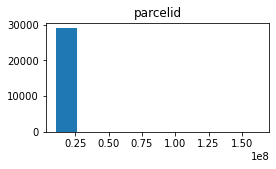

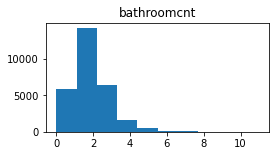

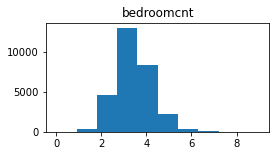

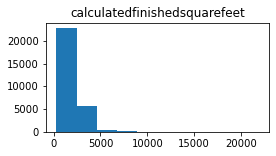

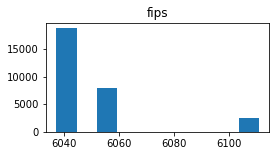

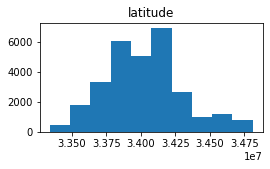

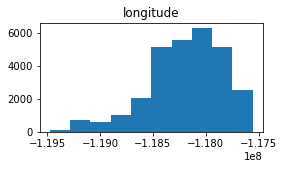

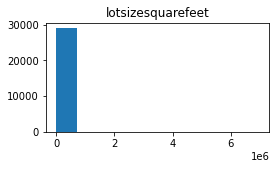

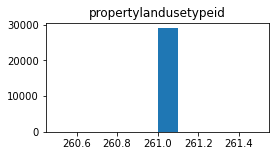

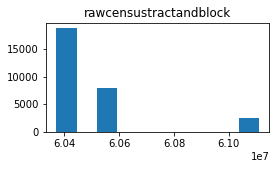

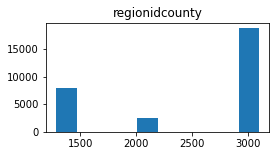

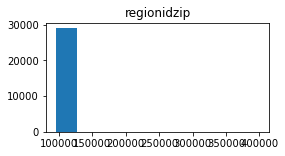

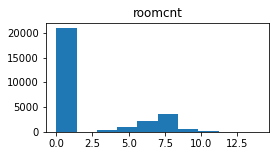

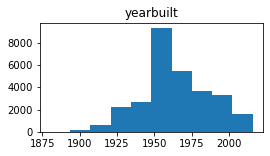

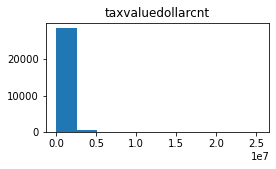

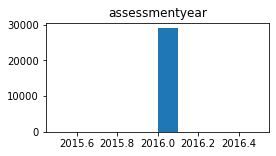

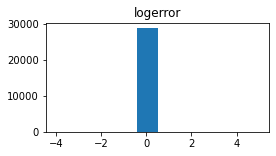

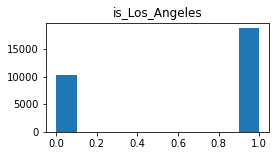

In [21]:
#create all the histograms:
for col in train.columns:
    plt.figure(figsize=(4,2))
    plt.hist(train[col])
    plt.title(col)
    plt.show()

### TAKEAWAYS:
- I'll add in some outlier ranges to help these distributions look at bit more 'normal'
- Some columns won't need to be changed (ie. latitude/longitude/zipcode/census/etc)

## Handling Outliers:

>I've decided to go by the outliers I used in my Regression model, by creating ranges of the columns below:
- Finished Squarefoot Range: 200sqft - 9_000sqft
- Bedroom Count range: 1-6bd
- Bathroom Count range:1-6bd
- Property Tax Value range: 45k - 2.5million

I also will be adding these ranges to outliers as well:
    - Year built